# Model with different optimization algorithms


We have already implemented a 3-layer neural network

1. Gradient Descent

2. Mini-batch Gradient Descent

3. Mini-batch GD with Momentum

4. Mini-batch GD with Adam

In [97]:
import numpy as np

import sklearn
import sklearn.datasets
import matplotlib.pyplot as plt
import time

from tools.nn_function import load_dataset_moons, init_parameters_he
from tools.activation_function import sigmoid, sigmoid_derivative, ReLU, ReLU_derivative, tanh, tanh_derivative
from tools.nn_function import forward_propagation, cost_function, backward_propagation, update_derivatives, plot_cost, predict, predict_dec, plot_decision_boundary


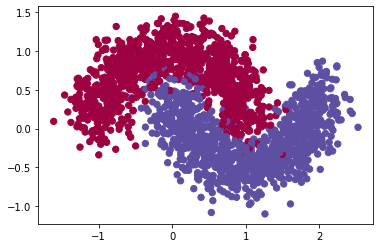

In [98]:
train_X, train_Y, test_X, test_Y = load_dataset_moons()
# train_X (2, 2000)  train_Y (1, 2000)

# Initialize Layers
Layers = [train_X.shape[0], 10, 2, 1]

# 1 - Gradient Descent without optimization

In [99]:
class Model ():
    def __init__(self, X, y, Layers, alpha = 0.1, iterations = 1000):
        self.X = X
        self.y = y
        
        self.Layers = Layers
        self.L_len = len(Layers)
        self.m = X.shape[1]
        # hyperparameters:
        self.alpha = alpha
        self.iterations = iterations

    def training_GD (self):
        X, y = self.X, self.y
        L_len, alpha = self.L_len, self.alpha
        J_arr = []
        print('======= 未优化 ======')
        params = init_parameters_he(self.Layers)
        for i in range(self.iterations):
            A = forward_propagation(X, params)
            if i % 100 == 0:
                J_arr.append(cost_function(A, y))
            grads = backward_propagation (A, y, params)
            params = update_derivatives (params, grads, alpha, L_len)
        plot_cost (J_arr, alpha)
        print('未优化 - 代价函数: ', J_arr[-1])
        return params 

======= 未优化 ======


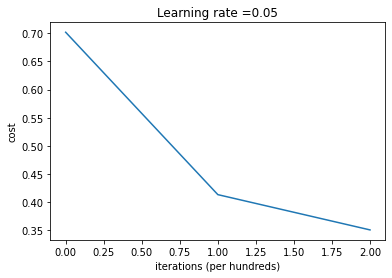

未优化 - 代价函数:  0.35097045913433533
***** 耗时 ***** 0.26230669021606445 s
===== Without Optimization =====
===== Accuracy: 88.05000000000001% =====


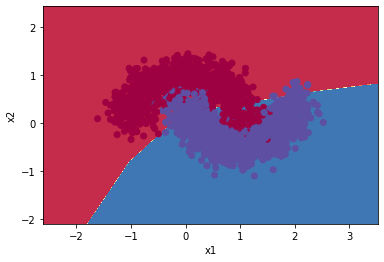

In [100]:
start = time.time()
params = Model(train_X, train_Y, Layers, 0.05, 300).training_GD()
end = time.time()
print('***** 耗时 *****', end-start, 's')

predict(train_X, train_Y, params, '===== Without Optimization =====')
plot_decision_boundary(lambda x: predict_dec(params, x.T), train_X, train_Y)


# 2 - Mini-Batch Gradient Descent

Steps: 
```python
# 1. @batch_interations
Given by batch_size, Compute the number of each mini-batch iterations
ps: batch_size 64 or 128 or .... 2^n

# 2. for j in range(batch_interations)

# 3. @mini_X, @mini_y
Separate mini-group for each computation
```

In [101]:
class Model ():
    def __init__(self, X, y, Layers, alpha = 0.1, iterations = 1000):
        self.X = X
        self.y = y
        
        self.Layers = Layers
        self.L_len = len(Layers)
        self.m = X.shape[1]
        # hyperparameters:
        self.alpha = alpha
        self.iterations = iterations

    def training_mini_batch (self, batch_size = 64):
        X, y = self.X, self.y
        L_len, alpha = self.L_len, self.alpha
        J_arr = []
        print('======= Mini-Batch Gradient Descent ======')
        params = init_parameters_he(self.Layers)
        
        # ======= START ======
        # STEP 1 - 分组
        batch_interations = int(np.ceil(self.m / batch_size))

        for i in range(self.iterations):
            # STEP 2 - 迭代
            for j in range(batch_interations):
                # STEP 3 - 分数据
                start, end = j * batch_size, (j + 1) * batch_size
                if (j == batch_interations - 1):
                    end = self.m
                mini_X = X[:, start: end] 
                mini_y = y[:, start: end]
                
                A = forward_propagation(mini_X, params)
                if i % 100 == 0:
                    J_arr.append(cost_function(A, mini_y))

                grads = backward_propagation (A, mini_y, params)
                params = update_derivatives (params, grads, alpha, L_len)
        # ======= END ======

        plot_cost (J_arr, alpha)
        print('Mini-Batch Gradient Descent 代价函数: ', J_arr[-1])
        return params 

======= Mini-Batch Gradient Descent ======


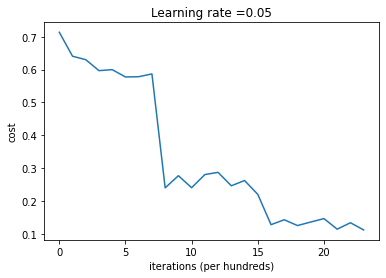

Mini-Batch Gradient Descent 代价函数:  0.111951201822293
***** 耗时 ***** 0.4653360843658447 s
===== Without Optimization =====
===== Accuracy: 96.85000000000001% =====


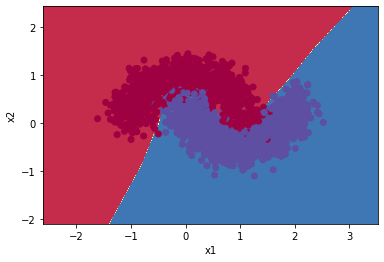

In [102]:
start = time.time()
params = Model(train_X, train_Y, Layers, 0.05, 300).training_mini_batch(batch_size = 256)
end = time.time()
print('***** 耗时 *****', end-start, 's')

predict(train_X, train_Y, params, '===== Without Optimization =====')
plot_decision_boundary(lambda x: predict_dec(params, x.T), train_X, train_Y)

# 3 - Mini-batch GD with Momentum

## 3.1 - Velocity

- 初始化值为0
- 理解: 在梯度下降时候的速度

$$V_{dw_i} = \beta * V_{dw_{i-1}} + (1 - \beta) * \frac{dJ}{dW_i}$$

$$W -= \alpha * V_{dw_i}$$

## 3.2 - Steps

```python
# 1. params: W, b, Velocity
Velocity: 创建和每层W, b 相同尺寸的matrix, 初始化值为0

# 2. hyperparameters: beta

# 3. update_derivatives
""" Before:
- dJ_dW, dJ_db
- W -= alpha * dJ_dW, b -= alpha * dJ_db
"""
# 3.1 dJ_dW, dJ_db
# 3.2 本层速度
    V_dJ_dw = beta * V_dJ_dw + (1 - beta) * dJ_dW
    V_dJ_db = beta * V_dJ_db + (1 - beta) * dJ_db
# 3.3 梯度下降
    W -= alpha * V_dJ_dw
    b -= alpha * V_dJ_db
```

In [103]:
class Model ():
    def __init__(self, X, y, Layers, alpha = 0.1, iterations = 1000):
        self.X = X
        self.y = y
        
        self.Layers = Layers
        self.L_len = len(Layers)
        self.m = X.shape[1]
        # hyperparameters:
        self.alpha = alpha
        self.iterations = iterations
        
    def init_velocity (self, params):
        velocity = {}
        for i in range(1, self.L_len):
            W = params['W' + str(i)]
            b = params['b' + str(i)]
            
            velocity['dJ_dW' + str(i)] = np.zeros_like(W)
            velocity['dJ_db' + str(i)] = np.zeros_like(b)
            
        return velocity
    
    def update_derivatives_with_momentum (self, params, grads, alpha, L_len, velocity, beta = 0.9):
        for l in range(1, L_len):
            # 3.1 dJ_dW, dJ_db
            dJ_dW = grads['dJ_dW' + str(l)]
            dJ_db = grads['dJ_db' + str(l)]
            
            # 3.2 本层速度
            velocity['dJ_dW' + str(l)] = beta * velocity['dJ_dW' + str(l)] + (1 - beta) * dJ_dW
            velocity['dJ_db' + str(l)] = beta * velocity['dJ_db' + str(l)] + (1 - beta) * dJ_db
            
            # 3.3 梯度下降
            params['W' + str(l)] -= alpha * velocity['dJ_dW' + str(l)]
            params['b' + str(l)] -= alpha * velocity['dJ_db' + str(l)]
            
        return params, velocity

    def training_mini_batch_with_momentum (self, batch_size = 64, beta = 0.9):
        print('======= Mini-Batch GD with Momentum ======')
        X, y = self.X, self.y
        L_len, alpha = self.L_len, self.alpha
        J_arr = []

        print('======= 1. initialize parameters ======')
        params = init_parameters_he(self.Layers)
        
        print('======= 2. initialize velocity by parameters ======')
        velocity = self.init_velocity(params)
        # print('velocity:', velocity)

        # ======= Mini-Batch With Momentum START ======
        batch_interations = int(np.ceil(self.m / batch_size))
        
        for i in range(self.iterations):
            for j in range(batch_interations):
                start, end = j * batch_size, (j + 1) * batch_size
                if (j == batch_interations - 1):
                    end = self.m
                mini_X = X[:, start: end] 
                mini_y = y[:, start: end]
                
                A = forward_propagation(mini_X, params)
                if i % 100 == 0:
                    J_arr.append(cost_function(A, mini_y))

                grads = backward_propagation (A, mini_y, params)
                
                # params = update_derivatives (params, grads, alpha, L_len)
                # ======= 3. update_derivatives_with_momentum ======
                params, velocity = self.update_derivatives_with_momentum (params, grads, alpha, L_len, velocity, beta)

        print('======= 3. update_derivatives_with_momentum ======')
        # ======= Mini-Batch With Momentum END ======

        plot_cost (J_arr, alpha)
        print('Mini-Batch GD with Momentum 代价函数: ', J_arr[-1])
        return params 

======= Mini-Batch GD with Momentum ======
======= 1. initialize parameters ======
======= 2. initialize velocity by parameters ======
======= 3. update_derivatives_with_momentum ======


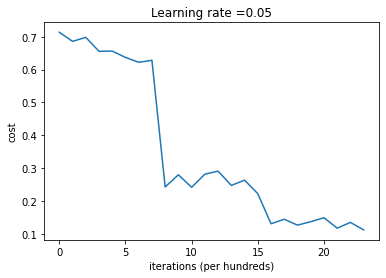

Mini-Batch GD with Momentum 代价函数:  0.11153350271058249
***** 耗时 ***** 0.49330687522888184 s
===== Optimization: Momentum =====
===== Accuracy: 96.75% =====


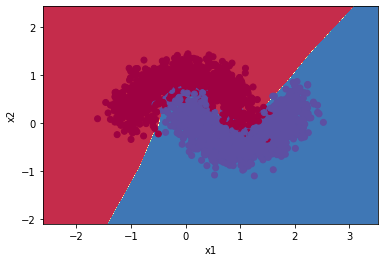

In [104]:
start = time.time()
params = Model(train_X, train_Y, Layers, 0.05, 300).training_mini_batch_with_momentum(batch_size = 256, beta = 0.9)
end = time.time()
print('***** 耗时 *****', end-start, 's')

predict(train_X, train_Y, params, '===== Optimization: Momentum =====')
plot_decision_boundary(lambda x: predict_dec(params, x.T), train_X, train_Y)

# 4 - Mini-batch GD with Adam

Momentum + RMSprop

## 4.1 - Velocity  Square  beta_v beta_s
`Momentum`

$$V_{dw_i} = \beta_v * V_{dw_{i-1}} + (1 - \beta_v) * \frac{dJ}{dW_i}$$


`RMSprop (root mean square prop)`

$$S_{dw_i} = \beta_s * S_{dw_{i-1}} + (1 - \beta_s) * (\frac{dJ}{dW_i}) ^ 2$$


`Compute`
$$W -= \alpha * \frac{V_{dw_i}}{\sqrt{S_{dw_i}}}$$



## 4.2 - Steps

`1. initialize velocity, square`
return velocity, square 

`2. beta_v, beta_s`

`3. update_derivatives`

`3.1 dJ_dw, dJ_db`

`3.2 compute S_dJ_dw, S_dJ_db`
- V_dJ_dw = beta_v * V_dJ_dw + (1 - beta_v) * dJ_dw
- V_dJ_db = beta_v * V_dJ_db + (1 - beta_v) * dJ_db

`3.3 compute S_dJ_dw, S_dJ_db`
- S_dJ_dw = beta_s * S_dJ_dw + (1 - beta_s) * (dJ_dw) ^ 2
- S_dJ_db = beta_s * S_dJ_db + (1 - beta_s) * (dJ_db) ^ 2

`3.4 update params`
- W -= alpha * V_dJ_dw / sqrt(S_dJ_dw)
- b -= alpha * V_dJ_db / sqrt(S_dJ_db)


In [105]:
class Model ():
    def __init__(self, X, y, Layers, alpha = 0.1, iterations = 1000):
        self.X = X
        self.y = y
        
        self.Layers = Layers
        self.L_len = len(Layers)
        self.m = X.shape[1]
        # hyperparameters:
        self.alpha = alpha
        self.iterations = iterations
        
    def init_velocity_square (self, params):
        velocity = {}
        square = {}
        for i in range(1, self.L_len):
            W = params['W' + str(i)]
            b = params['b' + str(i)]
            
            velocity['dJ_dW' + str(i)] = np.zeros_like(W)
            velocity['dJ_db' + str(i)] = np.zeros_like(b)
            
            square['dJ_dW' + str(i)] = np.zeros_like(W)
            square['dJ_db' + str(i)] = np.zeros_like(b)
            
        return velocity, square
    
    def update_derivatives_with_adam (self, params, grads, alpha, L_len, velocity, square, beta_v = 0.9, beta_s = 0.999):
        epsilon = 1e-8
        for l in range(1, L_len):
            # 3.1 dJ_dW, dJ_db
            dJ_dW = grads['dJ_dW' + str(l)]
            dJ_db = grads['dJ_db' + str(l)]
            
            # 3.2 velocity
            velocity['dJ_dW' + str(l)] = beta_v * velocity['dJ_dW' + str(l)] + (1 - beta_v) * dJ_dW
            velocity['dJ_db' + str(l)] = beta_v * velocity['dJ_db' + str(l)] + (1 - beta_v) * dJ_db
            
            # 3.3 square
            square['dJ_dW' + str(l)] = beta_s * square['dJ_dW' + str(l)] + (1 - beta_s) * np.power(dJ_dW, 2)
            square['dJ_db' + str(l)] = beta_s * square['dJ_db' + str(l)] + (1 - beta_s) * np.power(dJ_db, 2)
            
            
            # 3.4 update params
            params['W' + str(l)] -= alpha * (velocity['dJ_dW' + str(l)] / np.sqrt(square['dJ_dW' + str(l)] + epsilon))
            params['b' + str(l)] -= alpha * (velocity['dJ_db' + str(l)] / np.sqrt(square['dJ_db' + str(l)] + epsilon))
            
        return params, velocity, square

    def training_mini_batch_with_Adam (self, batch_size = 64, beta_v = 0.9, beta_s = 0.99):
        print('======= Mini-Batch GD with Adam ======')
        X, y = self.X, self.y
        L_len, alpha = self.L_len, self.alpha
        J_arr = []

        print('======= 1. initialize parameters ======')
        params = init_parameters_he(self.Layers)
        
        print('======= 2. initialize velocity, square ======')
        velocity, square = self.init_velocity_square(params)

        # ======= Mini-Batch With Adam START ======
        batch_interations = int(np.ceil(self.m / batch_size))

        for i in range(self.iterations):
            for j in range(batch_interations):
                start, end = j * batch_size, (j + 1) * batch_size
                if (j == batch_interations - 1):
                    end = self.m
                mini_X = X[:, start: end] 
                mini_y = y[:, start: end]
                
                A = forward_propagation(mini_X, params)
                if i % 100 == 0:
                    J_arr.append(cost_function(A, mini_y))
                grads = backward_propagation (A, mini_y, params)
                
                # params = update_derivatives (params, grads, alpha, L_len)
                # ======= 3. update_derivatives_with_adam ======
                params, velocity, square = self.update_derivatives_with_adam (params, grads, alpha, L_len, velocity, square, beta_v, beta_s)

        print('======= 3. update_derivatives_with_adam ======')
        # ======= Mini-Batch With Adam END ======

        plot_cost (J_arr, alpha)
        print('Mini-Batch GD with Adam 代价函数: ', J_arr[-1])
        return params 

======= Mini-Batch GD with Adam ======
======= 1. initialize parameters ======
======= 2. initialize velocity, square ======
======= 3. update_derivatives_with_adam ======


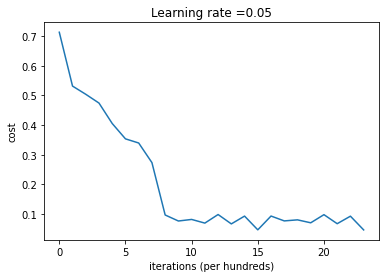

Mini-Batch GD with Adam 代价函数:  0.04604822042244434
***** 耗时 ***** 0.6198821067810059 s
===== Optimization: Adam =====
===== Accuracy: 97.15% =====


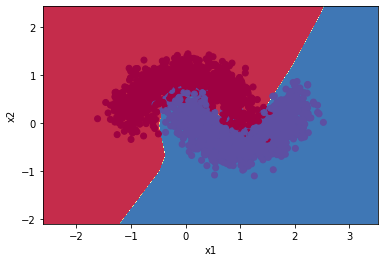

In [106]:
start = time.time()
params = Model(train_X, train_Y, Layers, 0.05, 300).training_mini_batch_with_Adam(batch_size = 256, beta_v = 0.9, beta_s = 0.999)
end = time.time()
print('***** 耗时 *****', end-start, 's')

predict(train_X, train_Y, params, '===== Optimization: Adam =====')
plot_decision_boundary(lambda x: predict_dec(params, x.T), train_X, train_Y)

# 5 - Conclusions

## 5 - 1 Experiment I

- alpha = 0.05
- interations = 1000

| type | loss | training accuracy | time |
| :--- | :----: | :----: | ---: |
| Gradient Descent | 0.237 | 91.8%  |  0.45s   |
| Mini-batch Gradient Descent   |  0.053    |  97.00%   |  1.10s   |
| Mini-batch GD with Momentum   |   0.050   |  97.05%   |  1.28s   |  
| **Mini-batch GD with Adam**   |  `0.047`  |  `97.39%`   |  1.63s   | 


## 5 - 2 Experiment II

- alpha = 0.05
- interations = 300

| type | loss | training accuracy | time |
| :--- | :----: | :----: | ---: |
| Gradient Descent | 0.350 | 88.05%  |  0.25s  |
| Mini-batch Gradient Descent   |  0.111    |  96.85%   |  0.46s   |
| Mini-batch GD with Momentum   |   0.111   |  96.75%   |  0.50s   |  
| **Mini-batch GD with Adam**   |  `0.046`  |  `97.15%`   |  0.58s   | 
